# UpPMaBoSS notebook for the cell fate model

UpPMaBoSS computes the evolution and the dynamics of a population of cells taking into account both their intracellular and intercellular regulations.

More specifically, UpPMaBoSS presents a method for simulating cell population dynamics. The simulation is based on logical models describing the intracellular regulations (with the details of the signalling pathways for each individual cell) and takes into account cell death, cell division, and intercellular communications. 

Each logical model of an individual cell is described as a MaBoSS model. At predefined intervals, the simulation of the cell population is stopped and the status of each cell of the population is updated according to the value of the variables representing cell death and cell division, and the value of the variables accounting for the activation or inhibition of signals coming from other cells. The simulation is then continued with the new updated conditions until the maximum simulation time is reached. Since MaBoSS results are probabilistic, the simulation outputs of UpPMaBoSS can be interpreted as the behaviour of a cell population. 

To run UpPMaBoSS, three files are needed: a model file (in BND format), a configuration file with the transition rates, the simulation parameters and the initial conditions (in CFG format), and a file defining the update parameters (in UPP format).


The notebook presented here shows an example of the use of UpPMaBoSS. For that, three files related to the logical model used for the analysis are required:

- the model files: *CellFateModel.bnd* and *CellFateModel.cfg*
- the update configuration file for UpPMaBoSS: *CellFate.upp* 

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os

import maboss
import umbs


# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

The cell fate model (Calzone et al., 2010, PLoS Comp Biol.) is a logical model studying the cell fate decision process in response to the engagement of the death receptors TNFR and Fas.  According to cell conditions, several pathways can be activated: survival through NFkB activation, death through necrosis (NonACD) and a programmed cell death (apoptosis).  

The BND file lists all the logical rules for each of the variables.
The CFG file defines all the parameters for the simulations (transition rates, simulation parameters and initial conditions).
The UPP file informs on the intercellular conditions and population updates.

In [2]:
# Set up the required files
bnd_file ="CellFateModel.bnd"
cfg_WT = "CellFateModel_1h.cfg"
upp_file = "CellFate_1h.upp"

# MaBoSS simulation of the wild type model

Before running UpPMaBoSS, we strongly suggest to run an initial simulation of the wild type model with MaBoSS for the whole simulation time. 

The purpose is to see how the population behaves in a normal MaBoSS run without taking into account cell death or cell division.  Here, the total simulation time is 48 hours. 
The output results are restricted to the three model nodes "Death", "Division" and "NFkB". Other nodes can be added in the output, but it is important to select at least the nodes that are used for the population updating, as shown in the UPP file below, since they are needed for the computation. By choosing them in the output, MaBoSS computes explicitly the values of these nodes:

In [3]:
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

death = Death;
division = Division ;
$TNF_induc u= $ProdTNF_NFkB*p[(NFkB,Death) = (1,0)];
steps = 48;
MaBoSS = MaBoSS



Note that the variable "Death" is monitoring death by apoptosis or by non-apoptotic cell death, and "Division" is reporting on the activity of NFkB.

In [4]:
# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)

# Set some parameters in the cfg file: "max_time" 
# and select the variables considered to be internal (not appearing in the resulting csv file)
# here, only the two outputs will appear: Death and Division in the figures
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h.network[name].is_internal = True


In [5]:
model_48h.network.set_output(('Death','Division','NFkB'))
run_48h = model_48h.run()

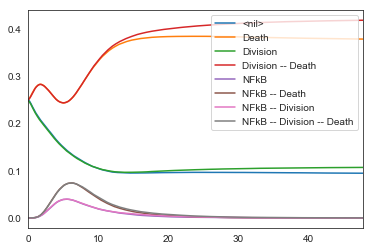

In [6]:
# Plot the results of the WT simulation
run_48h.get_states_probtraj().plot()

# Note that the model state <nil> means that none of the external variables are ON. 

# UpPMaBoSS simulations

We now wish to explore the population dynamics for the cell fate model considering cell death, cell division and intercellular events. 
To do so, we divide the 48 hours into 48 runs (the variable "steps" is set to 48 in CellFate.upp file) of 1 for each time steps (the variable "max_time" is set to 1 in CellFate_1h.cfg file). This choice of 1 is motivated by the shortest transient window in the MaBoSS simulation above.

## Wild Type simulations with and without the feedback

We consider two conditions: when the cells evolve without communications (model referred to as "NoFB") and when the presence of NFkB affects that status of other cells (model referred to as "WT"). The model with the feedback considers that NFkB activates TNFR of the neighbouring cells. 

In [7]:
# Run UpPMaBoSS on the WT model and collect population ratios
# A folder named "WT" "is created with the 16 runs
run_WT = umbs.UpP_MaBoSS(model_WT, upp_file, 'WT')
pop_ratios_WT = run_WT.get_population_ratios('NFkB -> TNF')

In [8]:
# Create a variant without the population feedback NFkB -> TNF
model_NoFB = maboss.copy_and_update_parameters(model_WT, {'$ProdTNF_NFkB': 0})

# Run UpPMaBoSS for the model without population feedback
# A folder named "NoFB" "is created with the 16 runs
run_NoFB = umbs.UpP_MaBoSS(model_NoFB, upp_file, 'NoFB')
pop_ratios_NoFB = run_NoFB.get_population_ratios('No NFkB -> TNF')

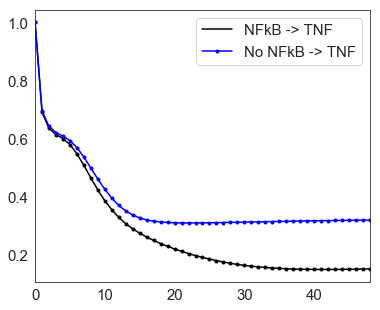

In [9]:
# Plot population ratio with/without population feedback
# A figure is saved in the folder with the name: "figure_ratios.pdf"
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=15)
pop_ratios_NoFB.plot(style='.-b', legend=True)
save_figure(figure, 'ratios')

## Simulations with and without TNF treatments

In this section, we simulate the effect of several scenarios for TNF treatments on the wild type cell fate model. 

We first run a simulation for 48 hours without TNF treatment. 

In [10]:
# Create a model with no TNF (TNF OFF)
model_noTNF = model_WT.copy()
model_noTNF.network.set_istate('TNF', [1,0])

# Run UpPMaBoSS for the model with no TNF
# A folder named "noTNF" "is created with the 16 runs
run_noTNF = umbs.UpP_MaBoSS(model_noTNF, upp_file, 'noTNF')
pop_ratios_noTNF = run_noTNF.get_population_ratios('No pulse TNF')

We then perform a treatment on a population of cells that received an initial TNF treatment (reTNF) and another treatment on a population that was not initially treated with TNF (reTNF_noTNF)

In [11]:
# Create a model for a second treatment of TNF
model_reTNF = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 20})

# Run UpPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "reTNF" "is created with the 16 runs
run_reTNF = umbs.UpP_MaBoSS(model_reTNF, upp_file, 'reTNF', previous_run=run_WT)
pop_ratios_reTNF = run_reTNF.get_population_ratios('TNF')

# Run UpPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 16 runs
run_noTNF_reTNF = umbs.UpP_MaBoSS(model_reTNF, upp_file, 'noTNF_reTNF', previous_run=run_noTNF)
pop_ratios_noTNF_reTNF = run_noTNF_reTNF.get_population_ratios('TNF')

We plot the population ratios for the two protocols: 
1. (Pulse of TNF) + TNF (or WT + reTNF), 
2. (no pulse of TNF) + TNF (noTNF + reTNF_noTNF). 

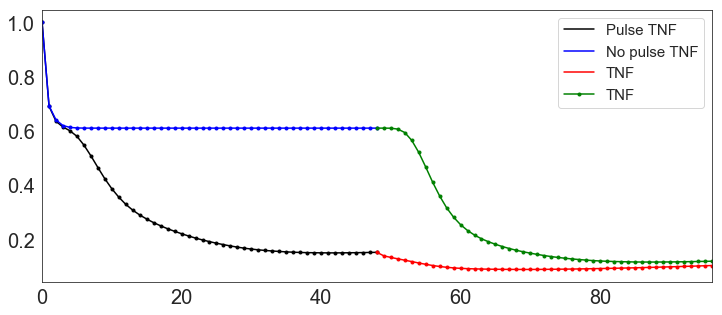

In [12]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation
# A figure "figure_two_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.name = "Pulse TNF"
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=20)
pop_ratios_noTNF.plot(style='.-b', legend=True)
pop_ratios_reTNF.plot(style='.-r', legend=True)
pop_ratios_noTNF_reTNF.plot(style='.-g', legend=True)
save_figure(figure, 'two_steps_ratios')

Based on these results, we conclude that the population that has received an initial treatment of TNF shows a resistance to the second TNF treatment: the population ratio between the two scenarios (with or without initial treatment of TNF) shows a difference (red vs. green). 

In conclusion, the cells that have not been treated previously respond better to the TNF treatment (green) than the ones that have been already treated (red).

# Study TNF resistance

In this section, we study the conditions for TNF resistance. 

The different protocols will be tested on single mutants of the model: 
- no pulse of TNF followed by no TNF, 
- no pulse of TNF followed by TNF, 
- pulse of TNF followed by no TNF, 
- pulse of TNF followed by TNF.

Note that a mutant of the model is defined by fixing the value of the corresponding variable to 0 (deletion) and ignore its logical rule. The different scenarios combining initial and secondary TNF treatments are simulated for each of the mutant.

A folder "TNF_sensitivity" is created in the working folder, which includes both WT and mutant simulations.

In [13]:
workdir = 'TNF_sensitivity'

def tnf_effect(workdir, model, name, df=None):
    "explore the effect of TNF in a given model variant"
    
    if df is None:
        df = pd.DataFrame()
    
    # Configuration of the model variants corresponding to combinations of (no) initial and secondary treatments
    model_pulse = model
    model_nopulse = model.copy()
    model_nopulse.network.set_istate('TNF', [1,0])
    
    model_tnf = maboss.copy_and_update_parameters(model, {'$TNF_induc':20})
    model_notnf = model
    
    # storage of all runs
    runs = {}
    
    # Simulations of no initial TNF pulse, then with or without constitutive TNF
    run_no_pulse = umbs.UpP_MaBoSS(model_nopulse, upp_file, os.path.join(workdir, name, 'nopulse'))
    runs['No pulse TNF, no TNF'] = umbs.UpP_MaBoSS(model_notnf, upp_file, os.path.join(workdir, name, 'noPulse_noTNF'), previous_run=run_no_pulse)
    runs['No pulse TNF, TNF'] = umbs.UpP_MaBoSS(model_tnf, upp_file, os.path.join(workdir, name, 'noPulse_TNF'), previous_run=run_no_pulse)

    # Simulations of initial TNF pulse, then with or without constitutive TNF
    run_pulse = umbs.UpP_MaBoSS(model_pulse, upp_file, os.path.join(workdir, name, 'pulse'))
    runs['Pulse TNF, no TNF'] = umbs.UpP_MaBoSS(model_notnf, upp_file, os.path.join(workdir, name, 'pulse_noTNF'), previous_run=run_pulse)
    runs['Pulse TNF, TNF'] = umbs.UpP_MaBoSS(model_tnf, upp_file, os.path.join(workdir, name, 'pulse_TNF'), previous_run=run_pulse)

    # Collection of population ratios
    for key in runs:
        pop_ratios = runs[key].get_population_ratios(key)
        if key not in df.columns:
            df[key] = pd.Series(name=name, dtype=np.float)
        df.at[name, key] = pop_ratios.iloc[-1]

    return df

All mutants for all protocols are simulated. 
Note that this could take a while (depending on your computer, it might take up to an hour).

In [14]:
# TNF sensitivity for the WT model
ratios = tnf_effect(workdir, model_WT, 'WT')

# List of all mutations to test
# Here all species will be mutated except for the output nodes
excluded = set( ( 'NonACD', 'Apoptosis', 'Survival', 'Division', 'Death', 'TNF', 'apoptosome') )
nodes = [ n for n in model_WT.network.names if n not in excluded ]
nodes.sort()


# TNF sensitivity for each mutant of the model
for mutant_node in nodes:
    print(mutant_node, end=' ')
    mut_model = maboss.copy_and_mutate(model_WT, [mutant_node], 'OFF')
    tnf_effect(workdir, mut_model, '%s' % mutant_node, ratios)

ATP BAX BCL2 CASP3 CASP8 Cyt_c DISC_FAS DISC_TNF FADD FASL IKK MOMP MPT NFkB RIP1 RIP1K RIP1ub ROS SMAC TNFR XIAP cFLIP cIAP mROS mXIAP mcIAP 

The four protocols are plotted for each of the mutant.

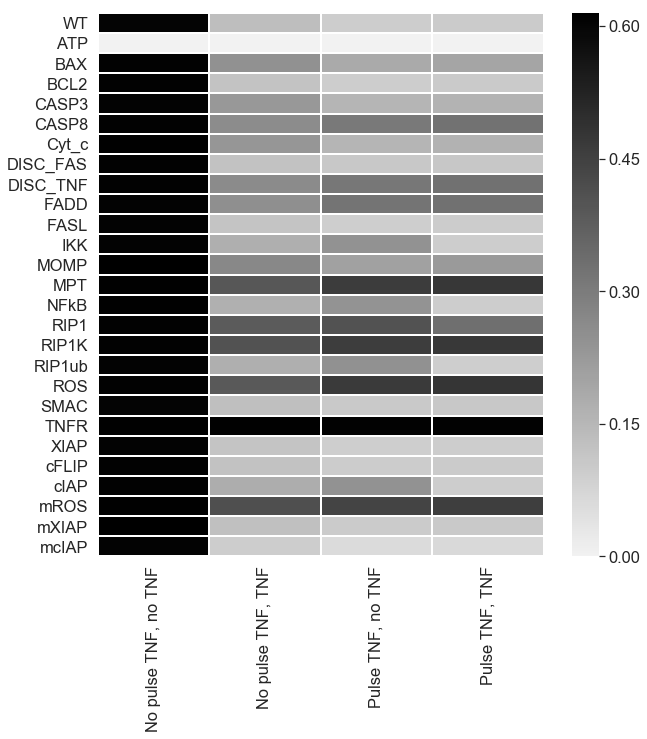

In [15]:
# Plot the TNF sensitivity results for the WT condition and for all mutants 
figure = plt.figure(figsize = (10,10))
sns.set(font_scale=1.5)
sns.heatmap(ratios, annot=False, cmap=colormap_scale, linewidths=1)
save_figure(figure, 'heatmap')

To further understand the resistance effect observed in mutant conditions, the two conditions "No initial TNF treatment" (No pulse TNF) and "Initial TNF treatment" (Pulse TNF) are separated. 
In both cases, the ratio between the population ratio of a secondary treatment and the population ratio of no secondary treatment is computed, and plotted. All the mutants for which the value with initial TNF treatment is higher that the value with no initial treatment show resistance.

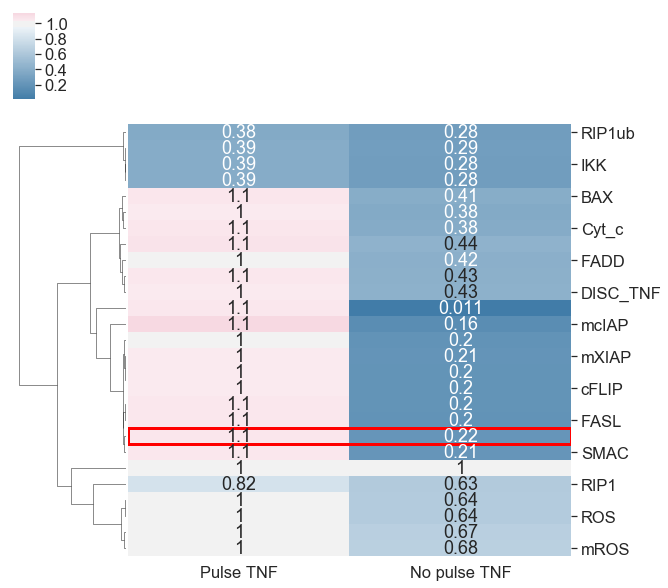

In [16]:
# More abstract summary: cluster of the ratios of ratios
ratios_ratios = pd.DataFrame()
ratios_ratios['Pulse TNF'] = ratios['Pulse TNF, TNF'] / ratios['Pulse TNF, no TNF']
ratios_ratios['No pulse TNF'] = ratios['No pulse TNF, TNF'] / ratios['No pulse TNF, no TNF']

sns.set(font_scale=1.5)
figure = sns.clustermap(ratios_ratios, annot=True, cmap=colormap_ratios, center=1, col_cluster=False)

# Add a rectangle around the WT row
wt_index = figure.dendrogram_row.reordered_ind.index(0)
figure.ax_heatmap.add_patch(Rectangle((0, wt_index), 2, 1, fill=False, edgecolor='red', lw=3))

save_figure(figure, 'cluster')